In [2]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [3]:
data_path = '/Users/ninadmohite/Downloads/1 2/1.1'
output_path = working_path = "/Users/ninadmohite/Downloads/"
g = glob(data_path + '/' + '*.dcm.dcma')

print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 78 DICOM images.
First 5 filenames:
/Users/ninadmohite/Downloads/1 2/1.1/ser601img00033.dcm.dcma
/Users/ninadmohite/Downloads/1 2/1.1/ser601img00032.dcm.dcma
/Users/ninadmohite/Downloads/1 2/1.1/ser601img00044.dcm.dcma
/Users/ninadmohite/Downloads/1 2/1.1/ser601img00045.dcm.dcma
/Users/ninadmohite/Downloads/1 2/1.1/ser601img00039.dcm.dcma


In [4]:
def load_scan(path):
    x = os.listdir(path)
    x.remove('.DS_Store')
   
    print(x)
    slices = [pydicom.dcmread(path + '/' + s, force = True) for s in x]
    #print(slices)
    print(slices[0])
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    #intercept = scans[0].RescaleIntercept
    #slope = scans[0].RescaleSlope
    intercept = scans[0].RescaleIntercept if 'RescaleIntercept' in scans[0] else -1024
    slope = scans[0].RescaleSlope if 'RescaleSlope' in scans[0] else 1
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

['ser601img00033.dcm.dcma', 'ser601img00032.dcm.dcma', 'ser601img00044.dcm.dcma', 'ser601img00045.dcm.dcma', 'ser601img00039.dcm.dcma', 'ser601img00038.dcm.dcma', 'ser601img00070.dcm.dcma', 'ser601img00071.dcm.dcma', 'ser601img00007.dcm.dcma', 'ser601img00006.dcm.dcma', 'ser601img00024.dcm.dcma', 'ser601img00025.dcm.dcma', 'ser601img00053.dcm.dcma', 'ser601img00052.dcm.dcma', 'ser601img00067.dcm.dcma', 'ser601img00066.dcm.dcma', 'ser601img00059.dcm.dcma', 'ser601img00058.dcm.dcma', 'ser601img00010.dcm.dcma', 'ser601img00011.dcm.dcma', 'ser601img00023.dcm.dcma', 'ser601img00022.dcm.dcma', 'ser601img00054.dcm.dcma', 'ser601img00055.dcm.dcma', 'ser601img00060.dcm.dcma', 'ser601img00061.dcm.dcma', 'ser601img00029.dcm.dcma', 'ser601img00028.dcm.dcma', 'ser601img00017.dcm.dcma', 'ser601img00016.dcm.dcma', 'ser601img00034.dcm.dcma', 'ser601img00035.dcm.dcma', 'ser601img00043.dcm.dcma', 'ser601img00042.dcm.dcma', 'ser601img00077.dcm.dcma', 'ser601img00076.dcm.dcma', 'ser601img00001.dcm.dcma', 

In [5]:
for i in patient:
    print(i.SliceThickness)

       
print ("Slice Thickness: %f" % patient[0].SliceThickness)
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.312492000000006
0.31249200

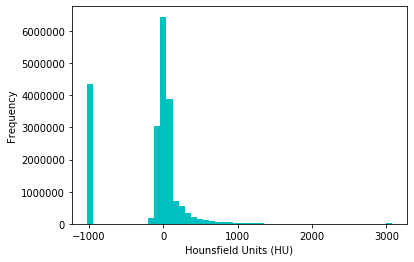

In [6]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

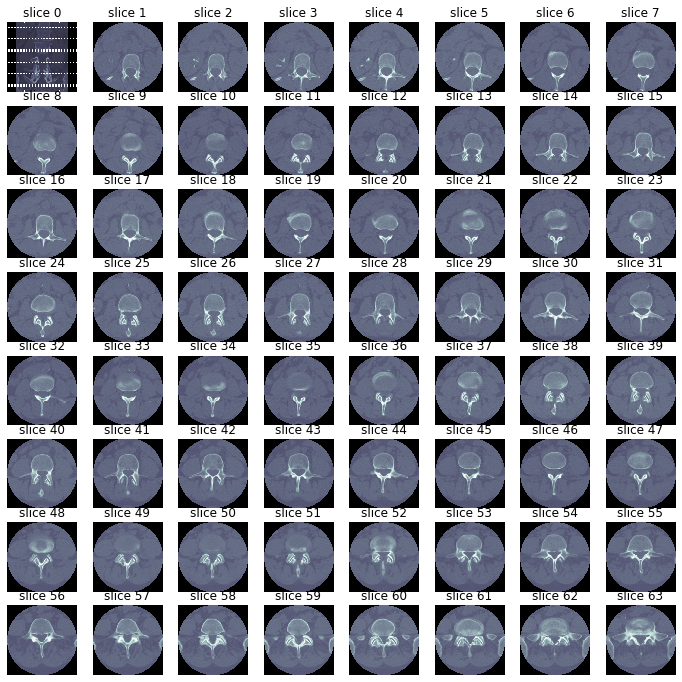

In [7]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=8, cols=8, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap=plt.cm.bone)
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [8]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([2.5] + list(scan[0].PixelSpacing), dtype=np.float32)
 
    spacing = np.array(spacing)
    print(spacing)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (78, 512, 512)
[2.5      0.371094 0.371094]
Shape after resampling	 (195, 190, 190)


In [16]:
#imgs_after_resamp = imgs_after_resamp.astype('float32')

In [17]:
imgs_after_resamp.dtype
import k3d
plot = k3d.plot()
isosurface = k3d.marching_cubes(imgs_after_resamp, level=1, color =0x801818)
plot += isosurface
plot.display()

/Users/ninadmohite/opt/anaconda3/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning:

Given trait value dtype "int16" does not match required type "float32". A coerced copy has been created.



Output()

In [18]:
imgs_after_resamp.dtype

dtype('int16')

In [39]:
pip install vtkplotter

Note: you may need to restart the kernel to use updated packages.


In [8]:
from vtkplotter import *

volume = load('/Volumes/Samsung_T5/L-SPINE_LSS_20160309_091629_240000/') #returns a vtkVolume object
print(volume)
show(volume, bg='white')


[None, None, None, None, None, None, None, None, None, None, None, None, None, None]


AttributeError: 'NoneType' object has no attribute 'ComputeVisiblePropBounds'

In [115]:
slices = [pydicom.dcmread(data_path + '/' + s, force = True) for s in os.listdir(data_path)]

for i in slices:
    
    print('The image has {} x {} voxels'.format(i.shape[0], i.shape[1]))

AttributeError: 'FileDataset' object has no attribute 'shape'

In [68]:
count=0
for s in slices:
    print("C",count)
    print(s.InstanceNumber)
    count+=1


C 0
50
C 1
51
C 2
33
C 3
36
C 4
32
C 5
37
C 6
19
C 7
18
C 8
41
C 9
44
C 10
40
C 11
45
C 12
8
C 13
9
C 14
27
C 15
26
C 16
13
C 17
12
C 18
39
C 19
38
C 20
70
C 21
71
C 22
7
C 23
2
C 24
6
C 25
3
C 26
24
C 27
21
C 28
25
C 29
20
C 30
47
C 31
46
C 32


AttributeError: 'FileDataset' object has no attribute 'InstanceNumber'

In [70]:
os.listdir(data_path)[32]

'.DS_Store'

In [73]:
os.listdir(data_path)

['ser603img00050.dcm.dcma',
 'ser603img00051.dcm.dcma',
 'ser601img00033.dcm.dcma',
 'ser602img00036.dcm.dcma',
 'ser601img00032.dcm.dcma',
 'ser602img00037.dcm.dcma',
 'ser603img00019.dcm.dcma',
 'ser603img00018.dcm.dcma',
 'ser602img00041.dcm.dcma',
 'ser601img00044.dcm.dcma',
 'ser602img00040.dcm.dcma',
 'ser601img00045.dcm.dcma',
 'ser602img00008.dcm.dcma',
 'ser602img00009.dcm.dcma',
 'ser603img00027.dcm.dcma',
 'ser603img00026.dcm.dcma',
 'ser603img00013.dcm.dcma',
 'ser603img00012.dcm.dcma',
 'ser601img00039.dcm.dcma',
 'ser601img00038.dcm.dcma',
 'ser601img00070.dcm.dcma',
 'ser601img00071.dcm.dcma',
 'ser601img00007.dcm.dcma',
 'ser602img00002.dcm.dcma',
 'ser601img00006.dcm.dcma',
 'ser602img00003.dcm.dcma',
 'ser601img00024.dcm.dcma',
 'ser602img00021.dcm.dcma',
 'ser601img00025.dcm.dcma',
 'ser602img00020.dcm.dcma',
 'ser603img00047.dcm.dcma',
 'ser603img00046.dcm.dcma',
 '.DS_Store',
 'ser603img00030.dcm.dcma',
 'ser603img00031.dcm.dcma',
 'ser602img00056.dcm.dcma',
 'ser6

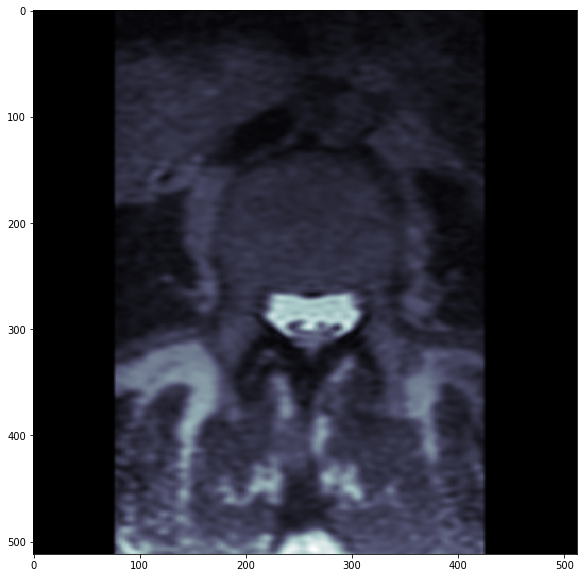

In [196]:

fi = pydicom.dcmread('/Users/ninadmohite/Downloads/1 2/1.2/ser300img00041.dcm.dcma', force = True)

#def plot_pixel_array(dataset, figsize=(10,10)):
plt.figure(figsize=(10,10))
plt.imshow(fi.pixel_array, cmap=plt.cm.bone)
plt.show()

In [110]:
def make_vertmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    #print(row_size)
    #print(col_size)
    
    mean = np.mean(img)
    #print(mean)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the vertebra
    # to renormalize washed out images 
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    #print(middle)
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    #print(threshold)
    thresh_img = np.where(img>threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the vertebra.  
    # We don't want to accidentally clip the vertebra.

    eroded = morphology.erosion(thresh_img,np.ones([2,2]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the vertebra are left, we do another large dilation
    #  in order to fill in and out the vertebra mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(dilation*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return dilation

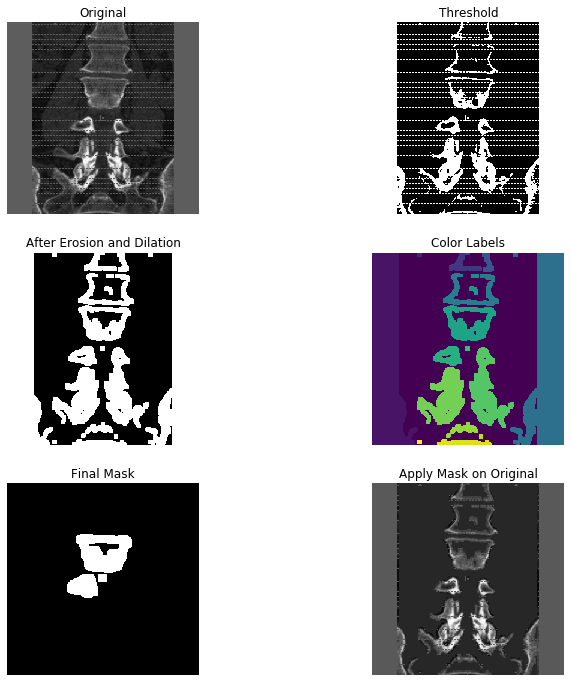

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [113]:
img = imgs_to_process[0]

make_vertmask(img, display=True)

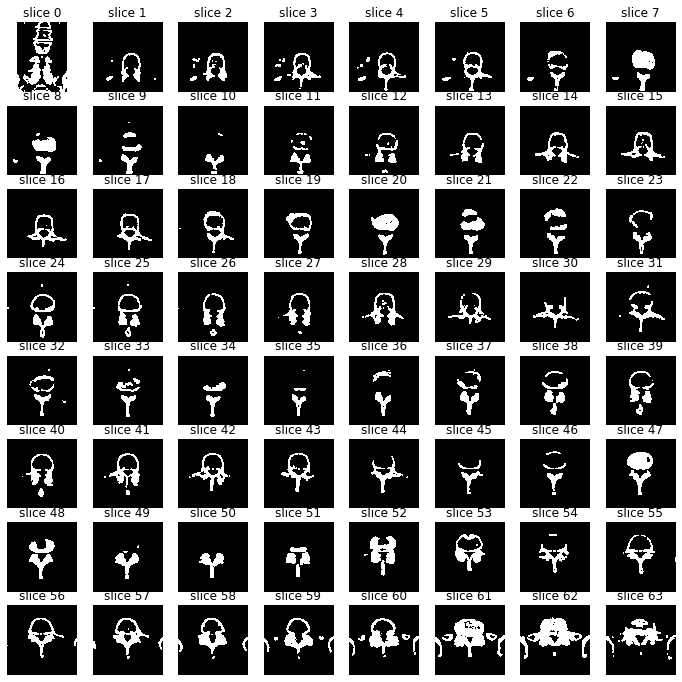

In [111]:
masked_vertebra = []

for img in imgs_to_process:
    masked_vertebra.append(make_vertmask(img))

sample_stack(masked_vertebra, show_every=1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, x)
Z = np.sin(X)*np.sin(Y)

levels = np.linspace(-1, 1, 40)

ax.contourf(X, Y, .1*np.sin(3*X)*np.sin(5*Y), zdir='z', levels=.1*levels)
ax.contourf(X, Y, 3+.1*np.sin(5*X)*np.sin(8*Y), zdir='z', levels=3+.1*levels)
ax.contourf(X, Y, 7+.1*np.sin(7*X)*np.sin(3*Y), zdir='z', levels=7+.1*levels)

ax.legend()
ax.set_xlim3d(0, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 10)

plt.show()

In [83]:
stack = np.stack(imgs_to_process)